In [1]:
import numpy as np
import matplotlib.pyplot as plt
import velocyto as vcy
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import JTSNEBASE, JTSNE
from sklearn.cluster import KMeans

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [3]:
expr_mat = pd.read_csv('/data/hoan/multiomics/data/snare_seq/GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv', sep='\t')

In [4]:
#atac_mat = pd.read_csv('data/snare_seq/GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv', sep = '\t')

# pre-processing gene expression data

In [5]:
scale_factor = 10000
expr_mat = expr_mat.values
expr_mat_log_t = np.log(scale_factor*expr_mat + 1.0)

In [6]:
expr_reduced = PCA(n_components=20).fit_transform(expr_mat_log_t.T)

In [7]:
joint_tsne = TSNE(init='random').fit_transform(expr_reduced)

In [8]:
from anndata import AnnData
import scanpy.api as sc
adata = AnnData(X=expr_reduced)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.louvain(adata, key_added='louvain', resolution = 0.2)
louv_labels = np.array(adata.obs['louvain'].tolist())
louv_labels = [int(x) for x in louv_labels]

/home/vanhoan310/miniconda3/envs/tsne/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [9]:
np.unique(louv_labels)

array([0, 1, 2, 3])

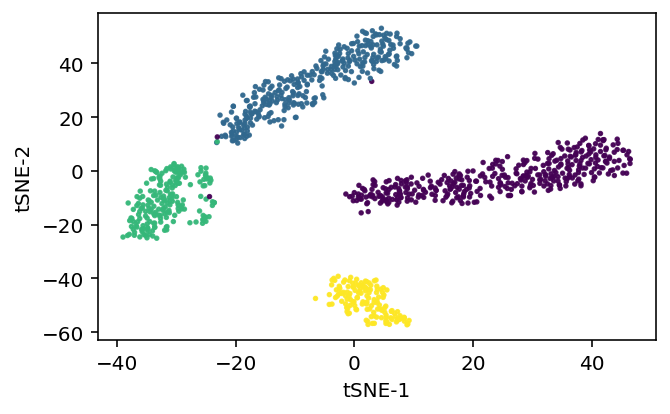

In [10]:
plt.figure(figsize=(5,3))
plt.scatter(joint_tsne[:,0], joint_tsne[:,1], s=3, c = louv_labels, alpha=0.9)
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.show()

In [11]:
def make_noise_numpy_data_shuffle(expression_matrix, prop, random_seed):
    np.random.seed(random_seed)
    n_rows, n_cols = expression_matrix.shape
    n_elem = round(prop*n_cols)
    s = np.arange(n_cols)
    for i in range(n_rows):
        row_id = list(np.random.choice(s, size=n_elem, replace=False))
        v = expression_matrix[i, row_id]
        np.random.shuffle(v)
        expression_matrix[i, row_id] = v

In [12]:
louv_labels = np.array(louv_labels)

In [13]:
cl1 = 0
cl2 = 1
selected_cells = (louv_labels==cl1) + (louv_labels==cl2)
expr_matsub = expr_mat[:, selected_cells]
make_noise_numpy_data_shuffle(expression_matrix = expr_matsub, prop = 0.8, random_seed = 0)
expr_copy = np.copy(expr_mat)                     
expr_copy[:, selected_cells] = expr_matsub

In [14]:
expr_matsub.shape, expr_copy.shape

((18666, 712), (18666, 1047))

In [15]:
scale_factor = 10000
expr_mat_log_t = np.log(scale_factor*expr_copy + 1.0)
expr_reduced = PCA(n_components=20).fit_transform(expr_mat_log_t.T)
tsne = TSNE(init='random').fit_transform(expr_reduced)

In [16]:
from matplotlib.colors import ListedColormap
colours = ListedColormap(['r','b','g', 'orange'])
classes = ['H1', 'BJ', 'K562', 'GM12878']

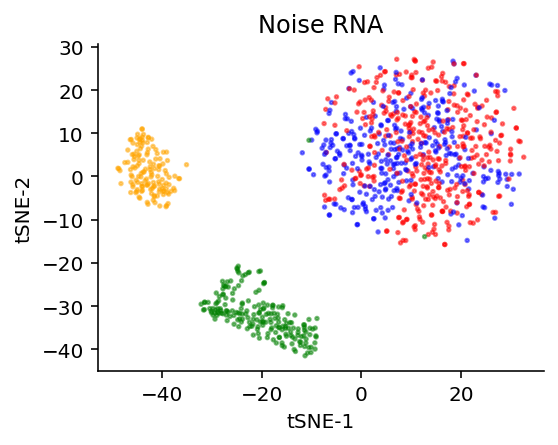

In [17]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.scatter(tsne[:,0], tsne[:,1], s=3, c = louv_labels, alpha=0.5, cmap=colours)
# ax.legend(handles=scatter.legend_elements()[0], labels=classes, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('Noise RNA')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('/data/hoan/plots/snare_tsne_noiseRNA.png', bbox_inches='tight')
plt.show()

# ATAC-seq

In [18]:
atacTopic_mat = pd.read_csv('/data/hoan/multiomics/data/snare_seq/GSE126074_CellLineMixture_SNAREseq_chromatin_topics.tsv', sep = '\t') 

In [19]:
atac_reduced = PCA(n_components=10).fit_transform(atacTopic_mat.values.T)

In [20]:
atac_reduced.shape

(1047, 10)

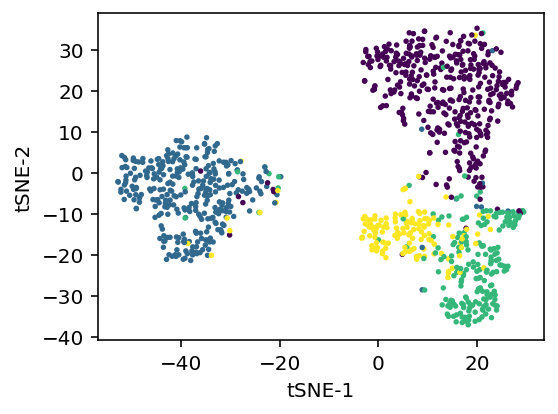

In [21]:
joint_tsne = TSNE(init='random').fit_transform(atac_reduced)
plt.figure(figsize=(4, 3))
plt.scatter(joint_tsne[:,0], joint_tsne[:,1], s=3, c = louv_labels)
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')
plt.show()

In [22]:
# joint_tsne = TSNE(init='random').fit_transform(atacTopic_mat.values.T)
# plt.figure(figsize=(8,6))
# plt.scatter(joint_tsne[:,0], joint_tsne[:,1],s=3, c = louv_labels)
# plt.xlabel('tSNE-1')
# plt.ylabel('tSNE-2')
# plt.show()

# Random modalities

In [23]:
noise_matrix = 100*np.random.rand(1047,20)

In [24]:
tsne_noisemodality = TSNE(init='pca').fit_transform(noise_matrix)

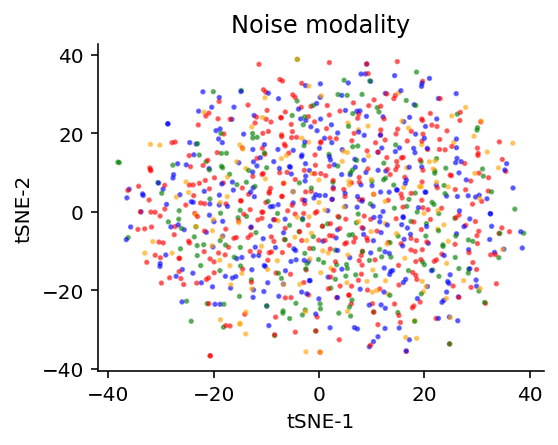

In [25]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.scatter(tsne_noisemodality[:,0], tsne_noisemodality[:,1], s=3, c = louv_labels, alpha=0.5, cmap=colours)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('Noise modality')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('/data/hoan/plots/snare_tsne_noisemodality.png', bbox_inches='tight')
plt.show()

# Joint visualization

In [26]:
expr_reduced.shape

(1047, 20)

In [27]:
data = {'rna': expr_reduced, 'chromatin': atac_reduced}
joint_tsne_obj = JTSNE(init='pca')
joint_tsne = joint_tsne_obj.fit_transform(X = data)

In [28]:
## Compute two metrics
from joint_metrics import *
kNN = 10
KNI_metrics = KNI(joint_tsne, louv_labels, kNN)
CARI_metrics = CARI(joint_tsne, louv_labels)
print("KNI: ", KNI_metrics, ", CARI: ", CARI_metrics)

KNI:  0.9455587392550143 , CARI:  0.8974717889174595


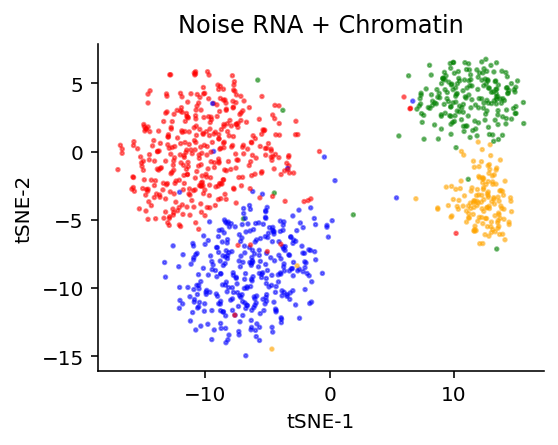

In [29]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.scatter(joint_tsne[:,0], joint_tsne[:,1], s=3, c = louv_labels, alpha=0.5, cmap=colours)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('Noise RNA + Chromatin')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('/data/hoan/plots/snare_tsne_noiseRNA_Chromatin.png', bbox_inches='tight')
plt.show()

# Joint tSNE 3 modalities

In [30]:
joint_tsne_obj = JTSNE(init='pca')
data = {'rna': expr_reduced, 'chromatin': atac_reduced, 'noise': noise_matrix}
joint_tsne = joint_tsne_obj.fit_transform(X = data, method = 'auto', _lambda = 3)

In [31]:
## Compute two metrics
KNI_metrics = KNI(joint_tsne, louv_labels, kNN)
CARI_metrics = CARI(joint_tsne, louv_labels)
print("KNI: ", KNI_metrics, ", CARI: ", CARI_metrics)

KNI:  0.9063037249283667 , CARI:  0.8526922954932203


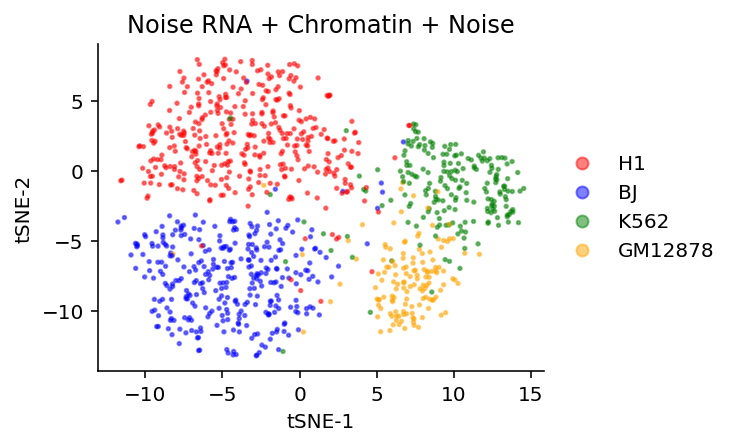

In [32]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
scatter =ax.scatter(joint_tsne[:,0], joint_tsne[:,1],s=3, c = louv_labels, alpha=0.5, cmap=colours)
lgd = ax.legend(handles=scatter.legend_elements()[0], labels=classes, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('Noise RNA + Chromatin + Noise')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('/data/hoan/plots/snare_tsne_3modalities.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [33]:
joint_tsne_obj.alpha

array([0.28874144, 0.5235619 , 0.18769665])

### Concat noise RNA + Chromatin

In [34]:
scale_factor = 10000
expr_mat_log_t = np.log(scale_factor*expr_copy + 1.0)
expr_mat_log_t.shape, atacTopic_mat.values.shape

((18666, 1047), (50, 1047))

In [35]:
concat2 = np.concatenate((expr_mat_log_t, atacTopic_mat.values), axis = 0)

expr_reduced = PCA(n_components=20).fit_transform(concat2.T)
concat_tsne = TSNE(init='random').fit_transform(expr_reduced)

In [36]:
## Compute two metrics
KNI_metrics = KNI(concat_tsne, louv_labels, kNN)
CARI_metrics = CARI(concat_tsne, louv_labels)
print("KNI: ", KNI_metrics, ", CARI: ", CARI_metrics)

KNI:  0.7952244508118433 , CARI:  0.5959451547883216


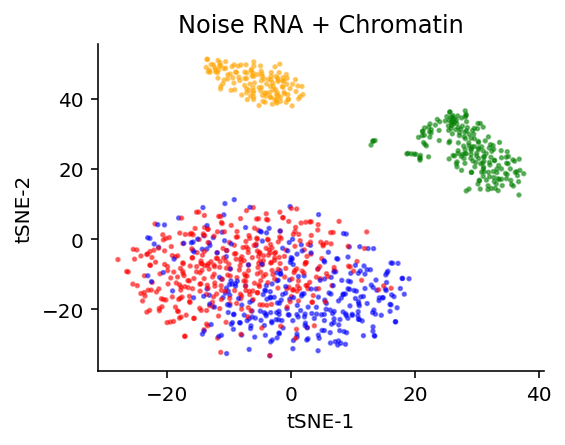

In [37]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.scatter(concat_tsne[:,0], concat_tsne[:,1], s=3, c = louv_labels, alpha=0.5, cmap=colours)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('Noise RNA + Chromatin')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('/data/hoan/plots/snare_tsne_concat_noiseRNA_Chromatin.png', bbox_inches='tight')
plt.show()

### Concat noise RNA + Chromatin + Noise

In [38]:
scale_factor = 10000
expr_mat_log_t = np.log(scale_factor*expr_copy + 1.0)
noisy_mat_scale = noise_matrix.T
concat3 = np.concatenate((expr_mat_log_t, atacTopic_mat.values, noisy_mat_scale), axis = 0)
expr_reduced = PCA(n_components=20).fit_transform(concat3.T)
concat_tsne3 = TSNE(init='random').fit_transform(expr_reduced)

In [39]:
## Compute two metrics
KNI_metrics = KNI(concat_tsne3, louv_labels, kNN)
CARI_metrics = CARI(concat_tsne3, louv_labels)
print("KNI: ", KNI_metrics, ", CARI: ", CARI_metrics)

KNI:  0.2898758357211079 , CARI:  -0.0015007541212004947


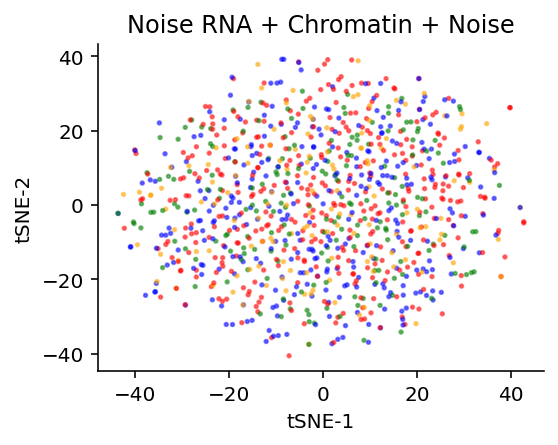

In [40]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.scatter(concat_tsne3[:,0], concat_tsne3[:,1], s=3, c = louv_labels, alpha=0.5, cmap=colours)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.set_title('Noise RNA + Chromatin + Noise')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('/data/hoan/plots/snare_tsne_concat_3modalities.png', bbox_inches='tight')
plt.show()